##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


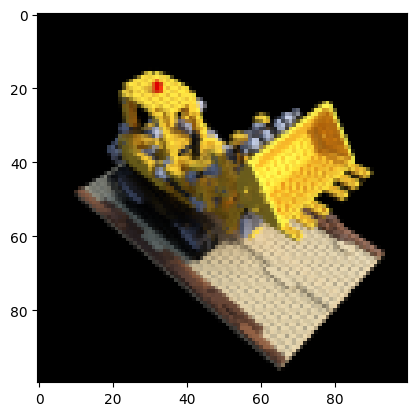

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize ZipNeRF

In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed,))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.keras.layers.Concatenate(axis=-1)([outputs, inputs])
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def multisample_rays(rays_o, rays_d, near, far, N_samples, rand=False):
    # Implement a multisampling pattern along the conical frustum
    z_vals = improved_proposal_network(rays_o, rays_d, near, far, N_samples)
    if rand:
        # Add multisample pattern (6-sample) for anti-aliasing
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    return pts, z_vals

def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    # Compute 3D query points with improved proposal network
    z_vals = improved_proposal_network(rays_o, rays_d, near, far, N_samples)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # Flatten points for input to the network
    pts_flat = tf.reshape(pts, [-1, 3])

    # Apply positional encoding and pass through the network
    pts_flat = embed_fn(pts_flat)
    raw = network_fn(pts_flat)

    # Reshape network output
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities (alpha) and colors (rgb)
    sigma_a = tf.nn.relu(raw[..., 3])  # Volume density
    rgb = tf.math.sigmoid(raw[..., :3])  # Color

    # Perform volume rendering using the weights
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[..., :1].shape)], -1)
    alpha = 1.0 - tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, axis=-1)
    acc_map = tf.reduce_sum(weights, axis=-1)

    return rgb_map, depth_map, acc_map


def improved_proposal_network(rays_o, rays_d, near, far, N_samples):
    # Implement dense resampling to avoid z-aliasing
    z_vals = tf.linspace(near, far, N_samples)
    # Dense resampling to capture thin structures
    z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    return z_vals



# Grid-Based Representation

In [ ]:
class GridFeatureRepresentation(tf.keras.layers.Layer):
    def __init__(self, grid_size=128):
        super(GridFeatureRepresentation, self).__init__()
        self.grid_size = grid_size
        self.grid = tf.Variable(tf.random.normal([grid_size, grid_size, grid_size, 3]), trainable=True)

    def call(self, x):
        # Convert x from world coordinates to grid coordinates
        x_grid = (x + 1) * 0.5 * (self.grid_size - 1)
        x_grid = tf.clip_by_value(x_grid, 0, self.grid_size - 1)
        return tf.gather_nd(self.grid, tf.cast(x_grid, tf.int32))

from tensorflow.keras.layers import Concatenate, Lambda

def init_model(D=8, W=256, grid_size=128):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act)

    # Input tensor with positional encoding (shape: (None, 3 + 3 * 2 * L_embed))
    inputs = tf.keras.Input(shape=(3 + 3 * 2 * L_embed,))

    # Use a Lambda layer to slice the first 3 dimensions (x, y, z coordinates)
    coords = Lambda(lambda x: x[:, :3])(inputs)

    # Use grid-based feature representation on 3D coordinates
    grid_layer = GridFeatureRepresentation(grid_size)
    grid_features = grid_layer(coords)  # Apply grid-based feature representation

    # Use Keras Concatenate to combine grid features with the original input (positional encoding)
    outputs = Concatenate(axis=-1)([grid_features, inputs])

    # Pass through the MLP layers
    for i in range(D):
        outputs = dense()(outputs)
        if i % 4 == 0 and i > 0:
            outputs = Concatenate(axis=-1)([outputs, inputs])

    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.007960710525512695 secs per iter


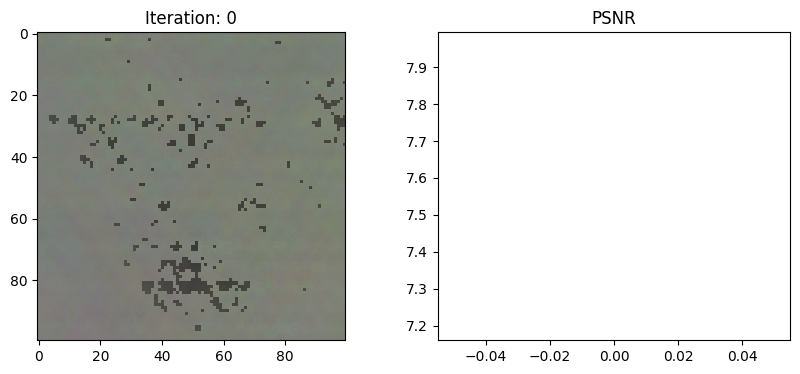

25 0.15482125282287598 secs per iter


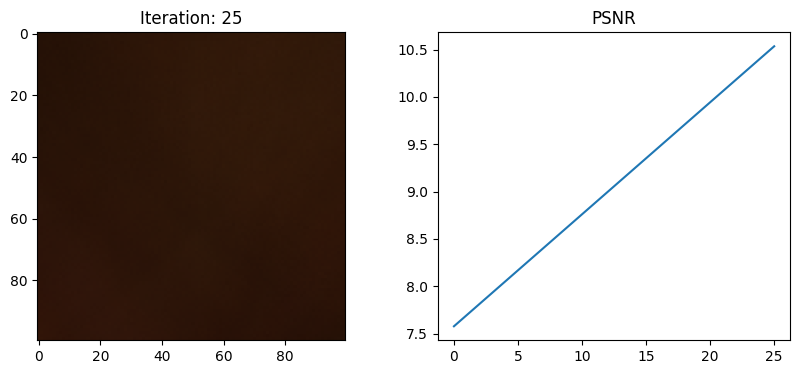

50 0.14771653175354005 secs per iter


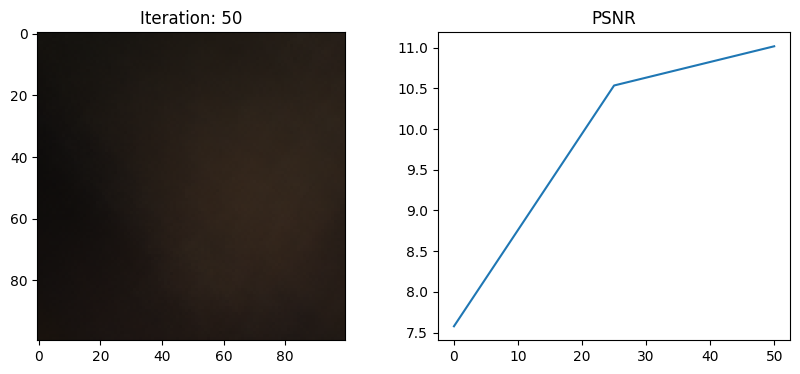

75 0.14757389068603516 secs per iter


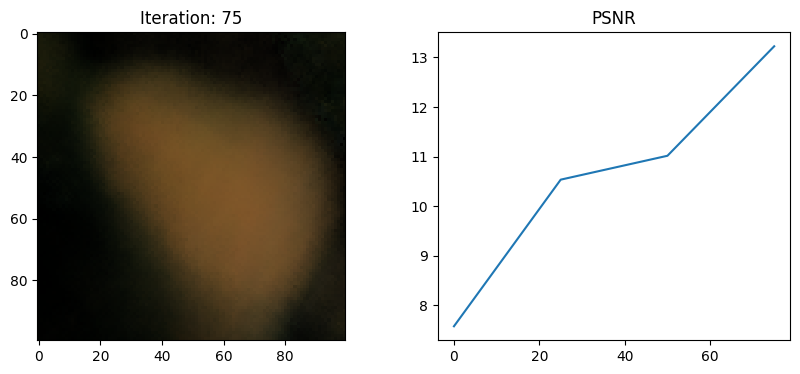

100 0.14927593231201172 secs per iter


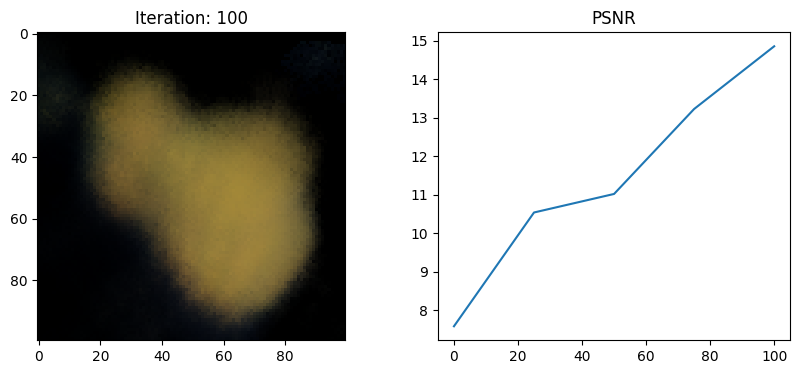

125 0.14653555870056154 secs per iter


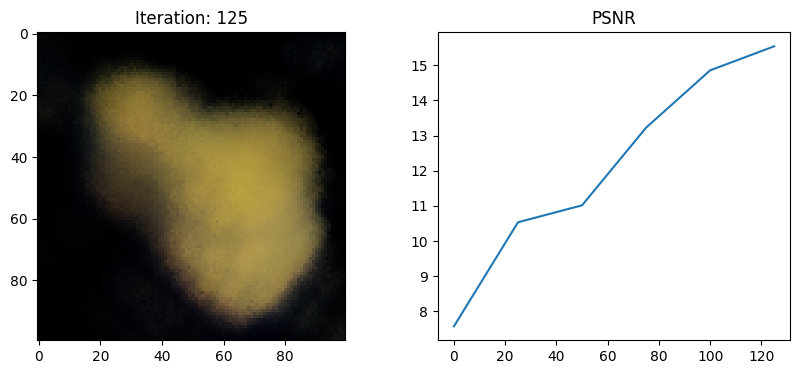

150 0.14579774856567382 secs per iter


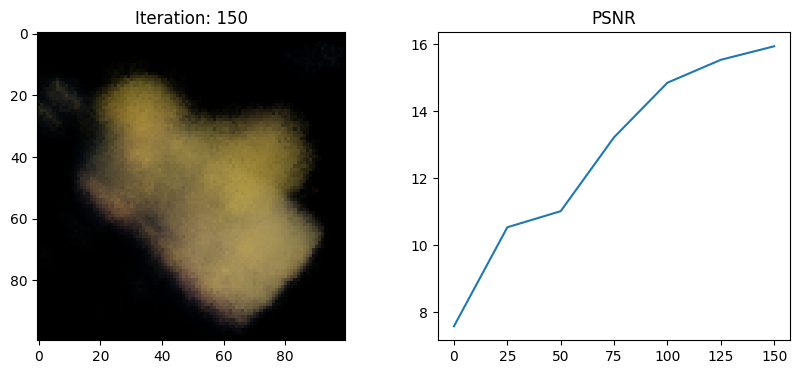

175 0.14789986610412598 secs per iter


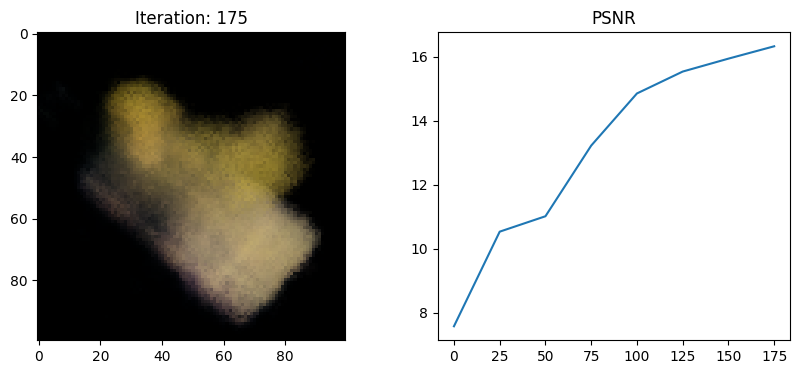

200 0.14439864158630372 secs per iter


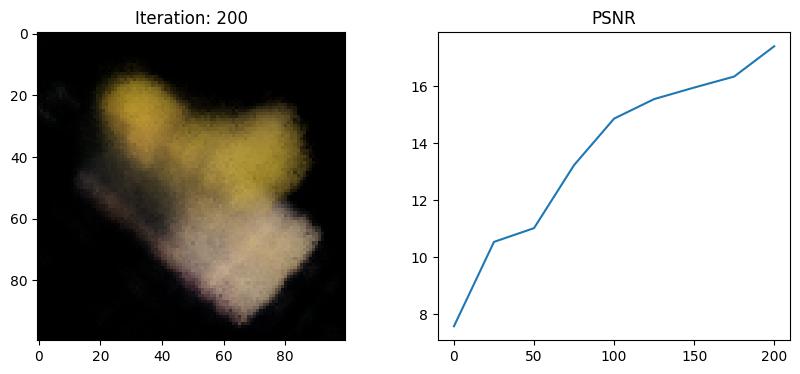

225 0.14339119911193848 secs per iter


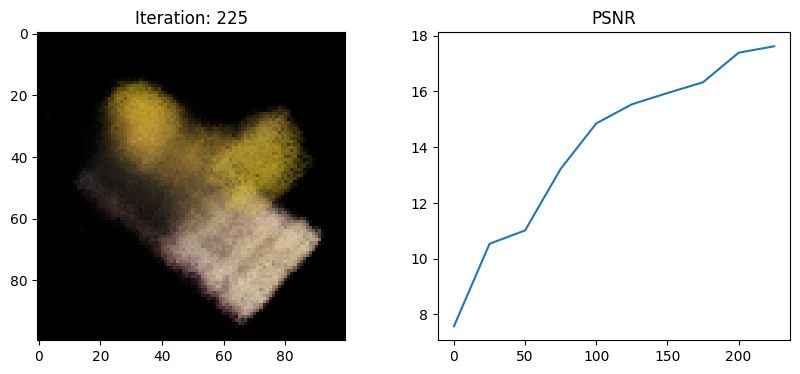

250 0.146162052154541 secs per iter


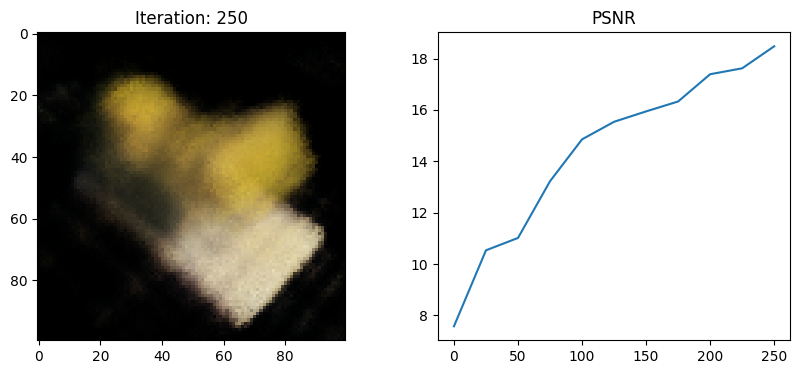

275 0.14468173027038575 secs per iter


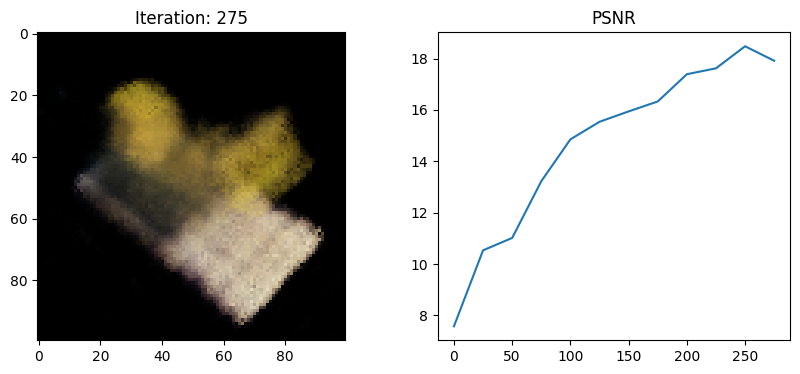

300 0.1451668357849121 secs per iter


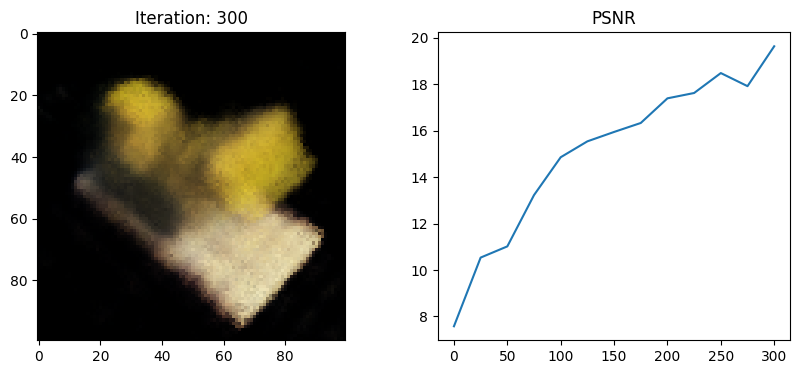

325 0.1450996780395508 secs per iter


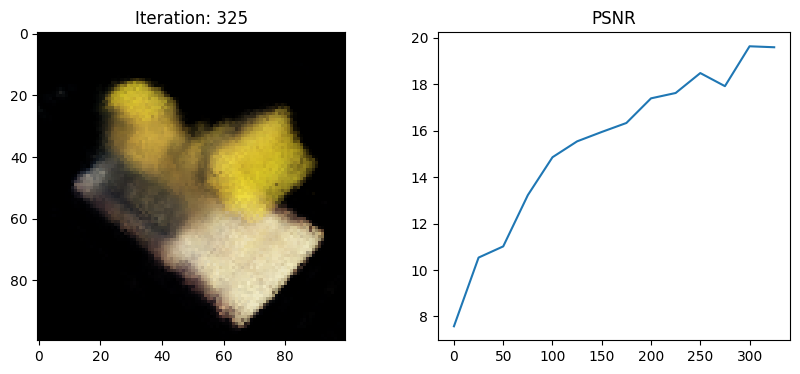

350 0.14655035972595215 secs per iter


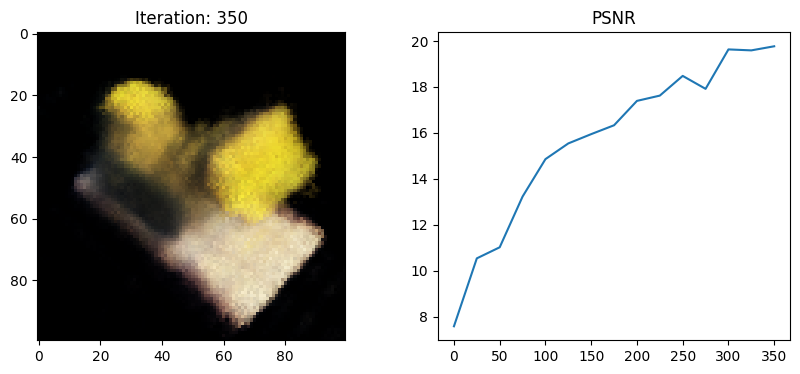

375 0.14746623039245604 secs per iter


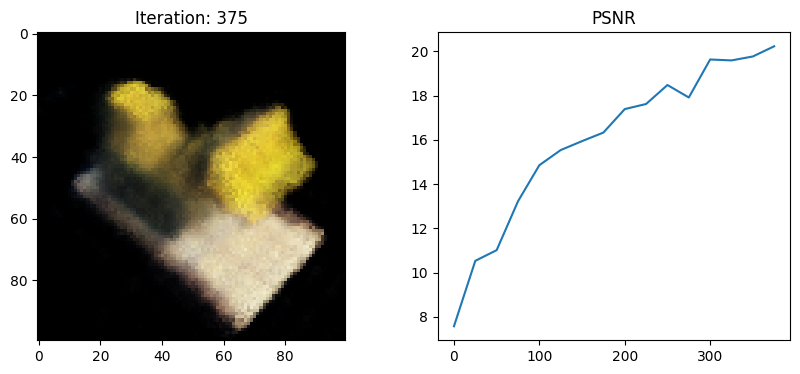

400 0.1473171043395996 secs per iter


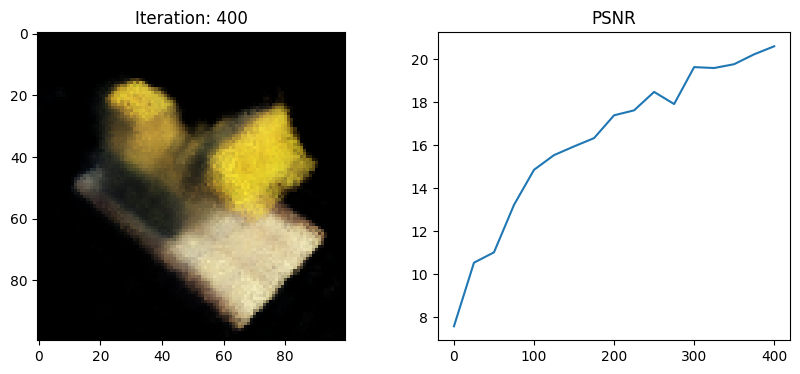

425 0.14461718559265135 secs per iter


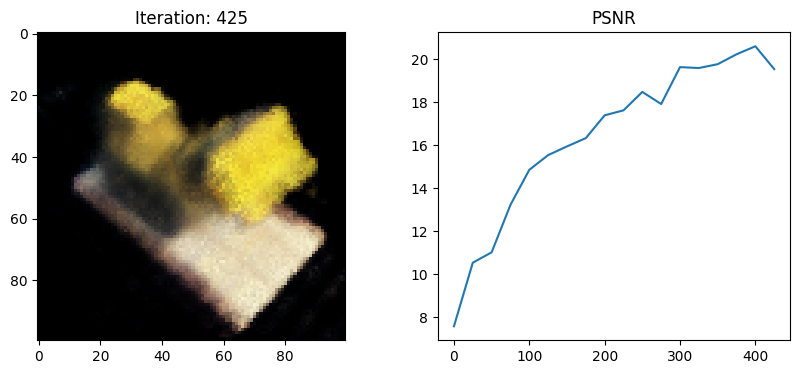

450 0.14496609687805176 secs per iter


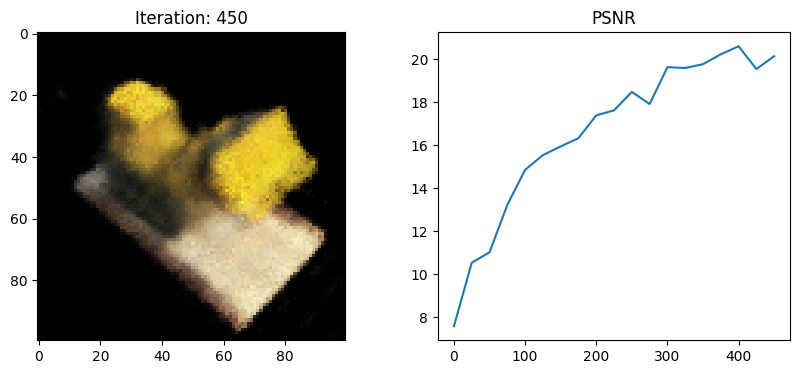

475 0.14599175453186036 secs per iter


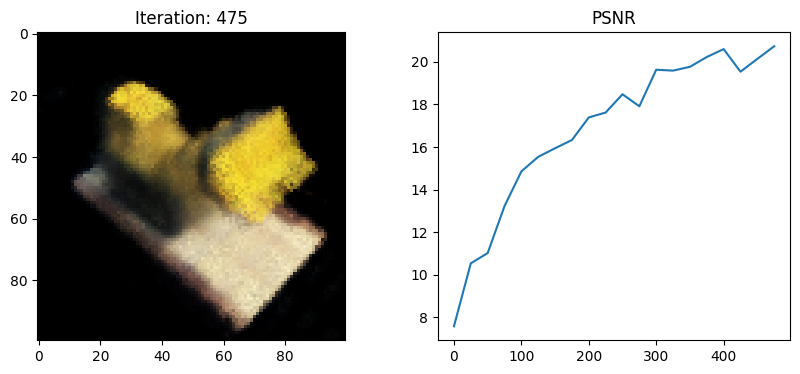

500 0.1466305923461914 secs per iter


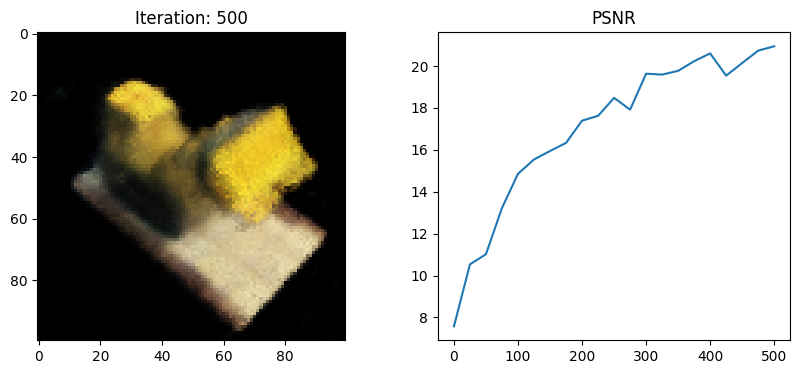

525 0.14775766372680665 secs per iter


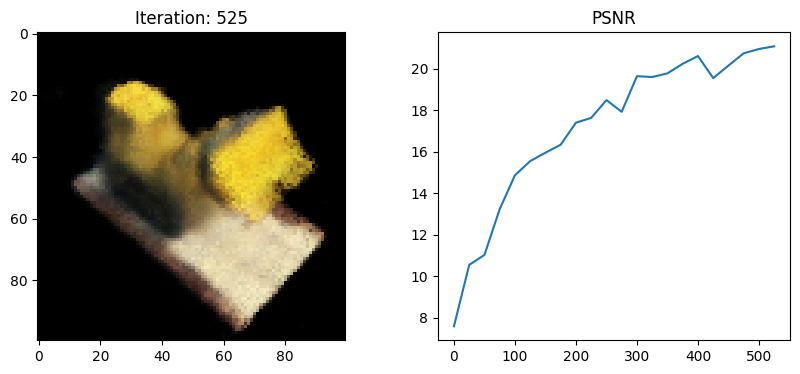

550 0.14388672828674318 secs per iter


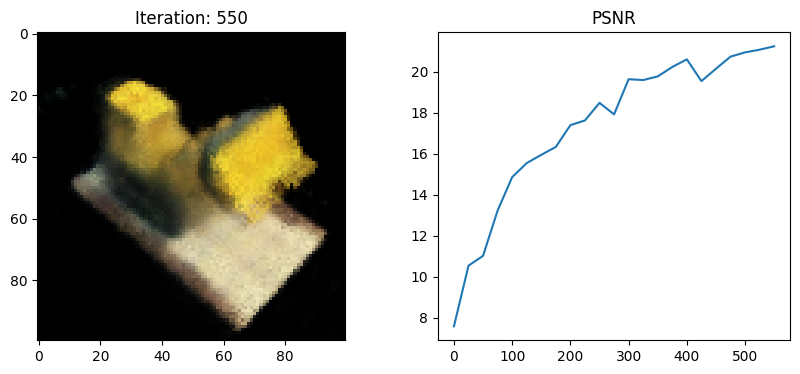

575 0.1565524673461914 secs per iter


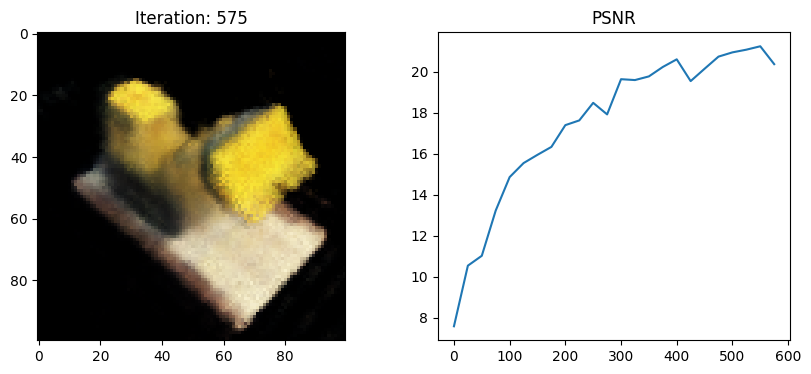

600 0.1463723087310791 secs per iter


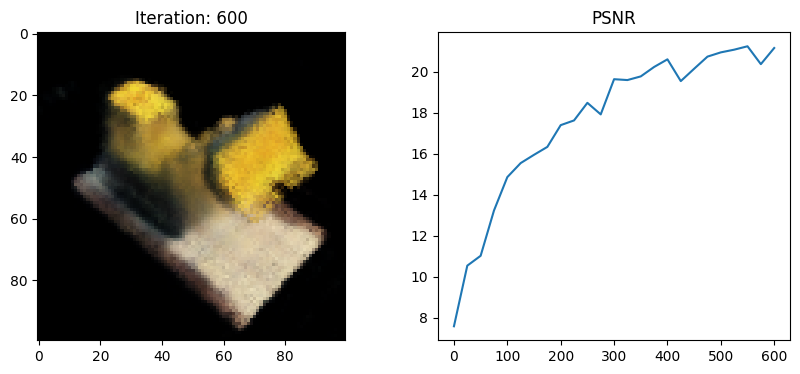

625 0.14665916442871094 secs per iter


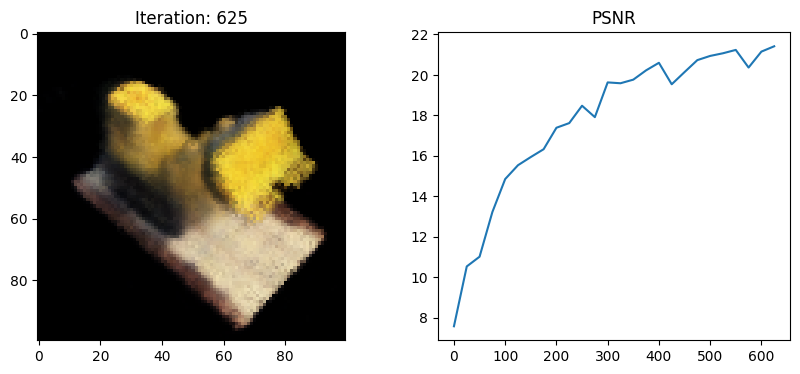

650 0.14809052467346193 secs per iter


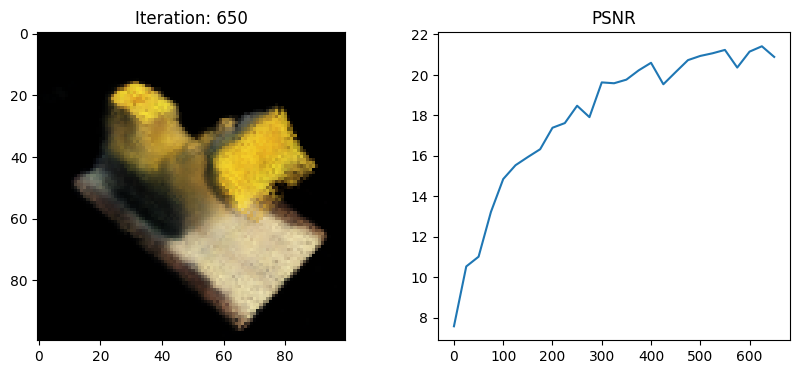

675 0.14748386383056641 secs per iter


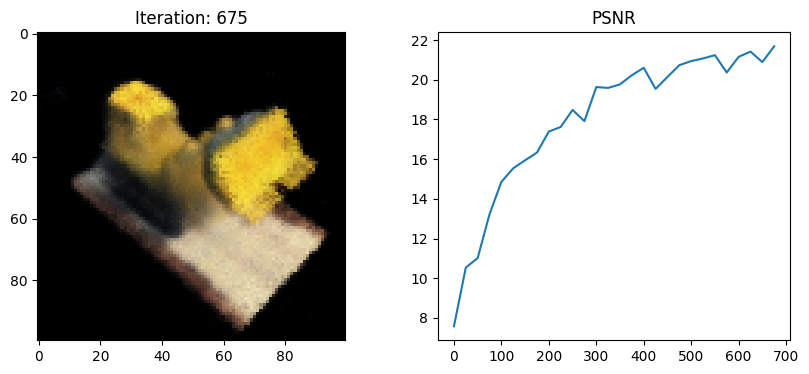

700 0.1462395477294922 secs per iter


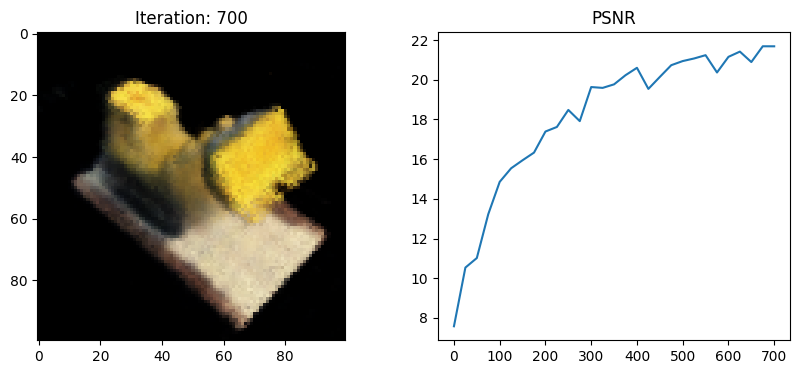

725 0.14666832923889161 secs per iter


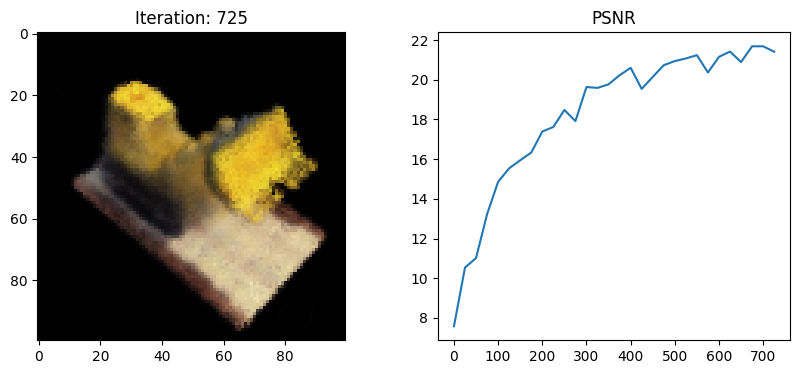

750 0.14746679306030275 secs per iter


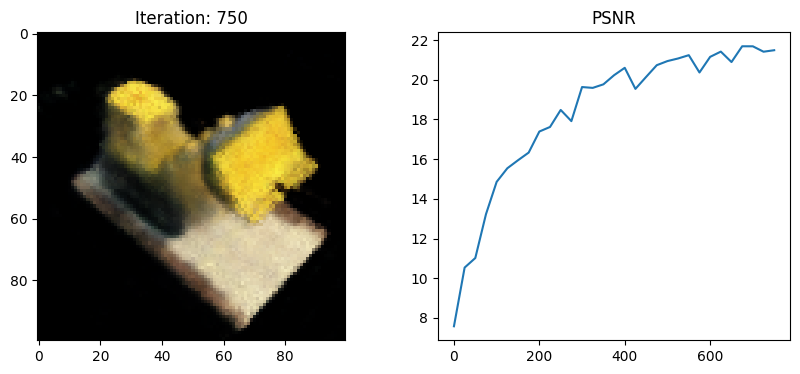

775 0.14685791015625 secs per iter


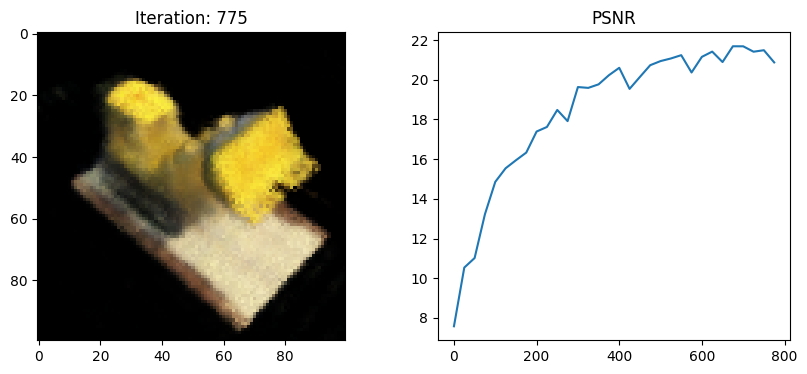

800 0.14439780235290528 secs per iter


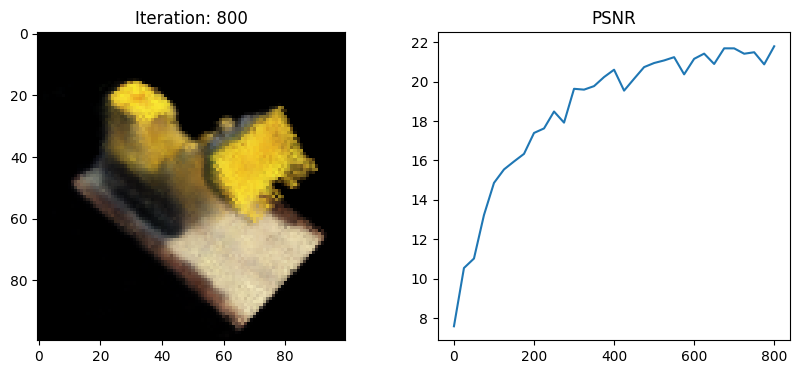

825 0.14252745628356933 secs per iter


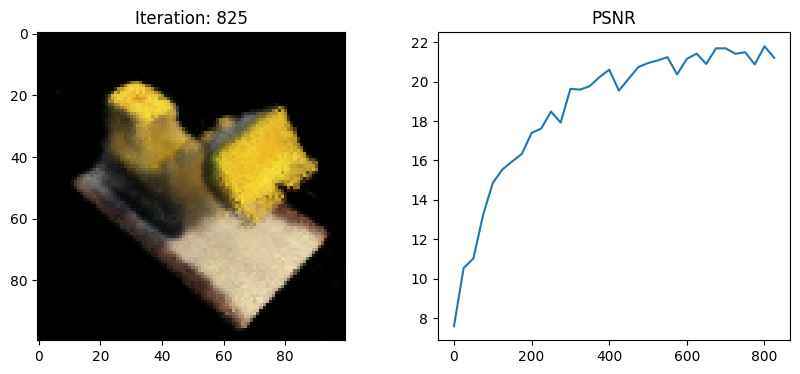

850 0.1426820659637451 secs per iter


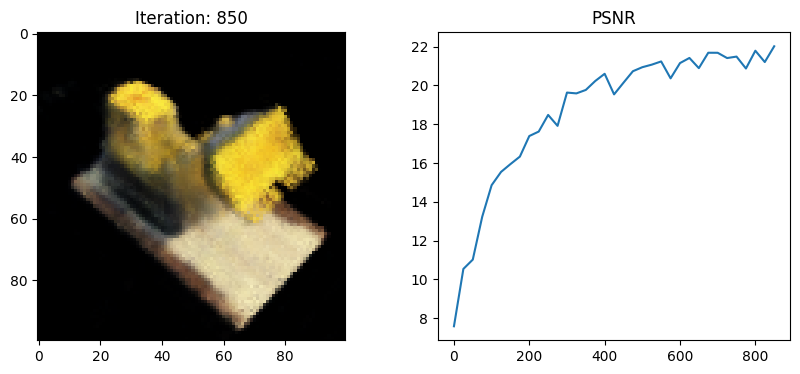

875 0.14299933433532716 secs per iter


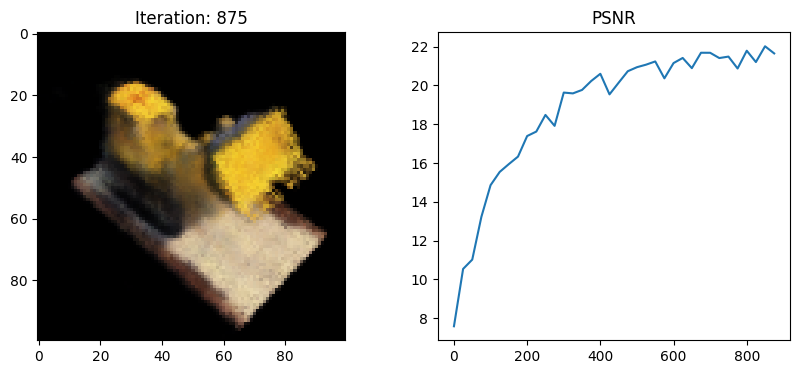

900 0.14329833984375 secs per iter


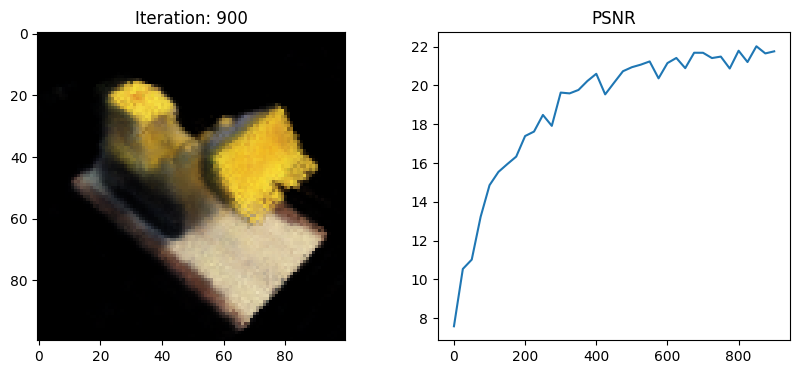

925 0.14334985733032227 secs per iter


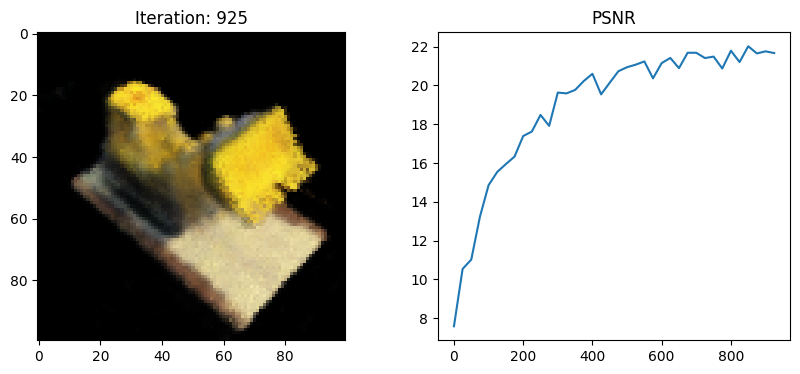

950 0.14246514320373535 secs per iter


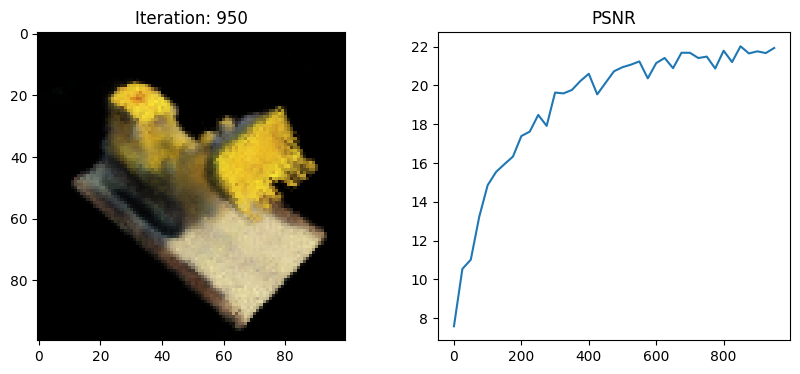

975 0.14143277168273927 secs per iter


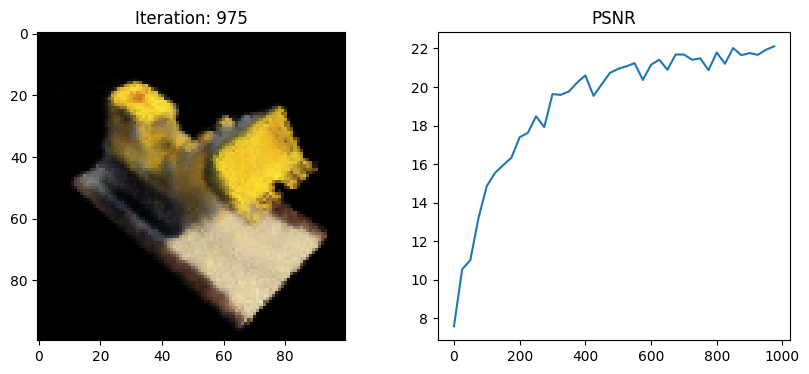

1000 0.1420891761779785 secs per iter


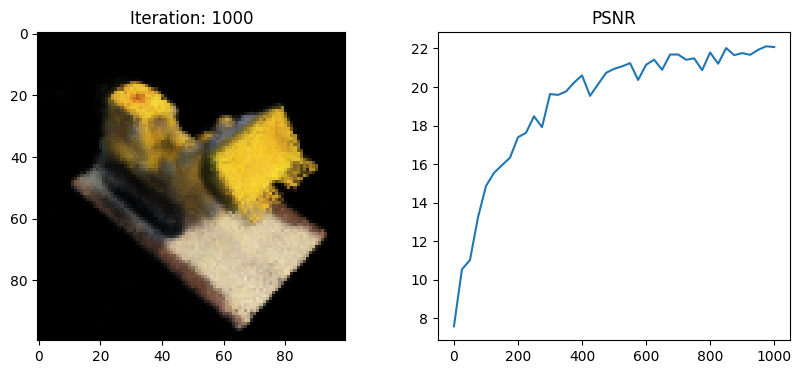

Done


In [ ]:
# Initialize model with grid-based representation
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters + 1):

    # Randomly select an image and its pose
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]

    # Get the rays from the camera
    rays_o, rays_d = get_rays(H, W, focal, pose)

    # Compute gradients using the improved render_rays function
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))

    # Apply gradients to update model weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log and plot every i_plot iterations
    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        # Record PSNR for visualization
        psnrs.append(psnr.numpy())
        iternums.append(i)

        # Plot the current rendered image and PSNR plot
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')


# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

<ipython-input-56-bc28ed268829>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Edge Detection, performance check

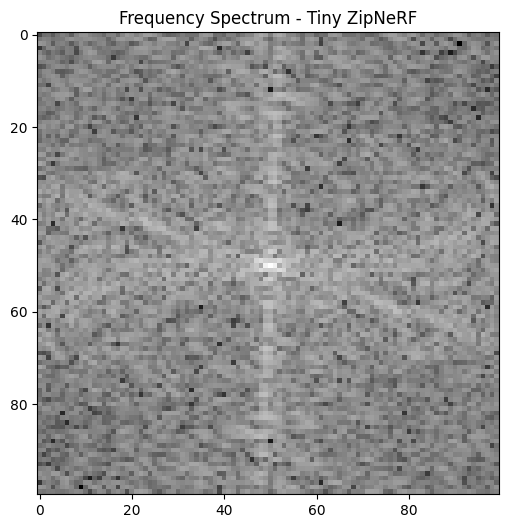

Temporal Consistency - Tiny ZipNeRF: 0.007096353
High-Frequency Content - Tiny ZipNeRF: 8.6064


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Render a test image with the Tiny ZipNeRF model
test_image_zipnerf = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)[0]

# Edge Frequency Analysis
def frequency_analysis(rgb_image):
    edges = cv2.Canny((rgb_image.numpy() * 255).astype(np.uint8), 100, 200)
    f_transform = np.fft.fftshift(np.fft.fft2(edges))
    magnitude_spectrum = 20 * np.log(np.abs(f_transform) + 1)
    return magnitude_spectrum

# Calculate Frequency Spectrum for Tiny ZipNeRF
magnitude_spectrum_zipnerf = frequency_analysis(test_image_zipnerf)
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum_zipnerf, cmap='gray')
plt.title('Frequency Spectrum - Tiny ZipNeRF')
plt.show()

# Temporal Consistency Calculation
def temporal_consistency(frames):
    differences = []
    for i in range(1, len(frames)):
        diff = np.mean(np.abs(frames[i] - frames[i - 1]))
        differences.append(diff)
    return np.mean(differences)
def pose_shift(pose, shift=0.1):
    new_pose = np.copy(pose)
    new_pose[:3, 3] += shift
    return new_pose

# Generate a Sequence of Frames with Slight Camera Changes
camera_poses = [pose_shift(testpose, shift=0.1 * i) for i in range(5)]
frames_zipnerf = [render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)[0] for pose in camera_poses]
temporal_consistency_zipnerf = temporal_consistency(frames_zipnerf)
print("Temporal Consistency - Tiny ZipNeRF:", temporal_consistency_zipnerf)

# High-Frequency Content Analysis
def high_frequency_content(rgb_image):
    laplacian = cv2.Laplacian((rgb_image.numpy() * 255).astype(np.uint8), cv2.CV_64F)
    return np.mean(np.abs(laplacian))

hf_content_zipnerf = high_frequency_content(test_image_zipnerf)
print("High-Frequency Content - Tiny ZipNeRF:", hf_content_zipnerf)
